    tiles_production  Tiles_Red  Tiles_Black  Operarios  Inyectoras
0                  7          2            5          1           1
1                  7          2            5          1           1
2                  7          2            5          1           1
3                  7          2            5          1           2
4                  7          2            5          1           2
5                  7          2            5          1           2
6                  7          2            5          1           3
7                  7          2            5          1           3
8                  7          2            5          1           3
9                  7          2            5          1           4
10                 7          2            5          1           4
11                 7          2            5          1           4
12                12          4            8          2           1
13                12          4            8    

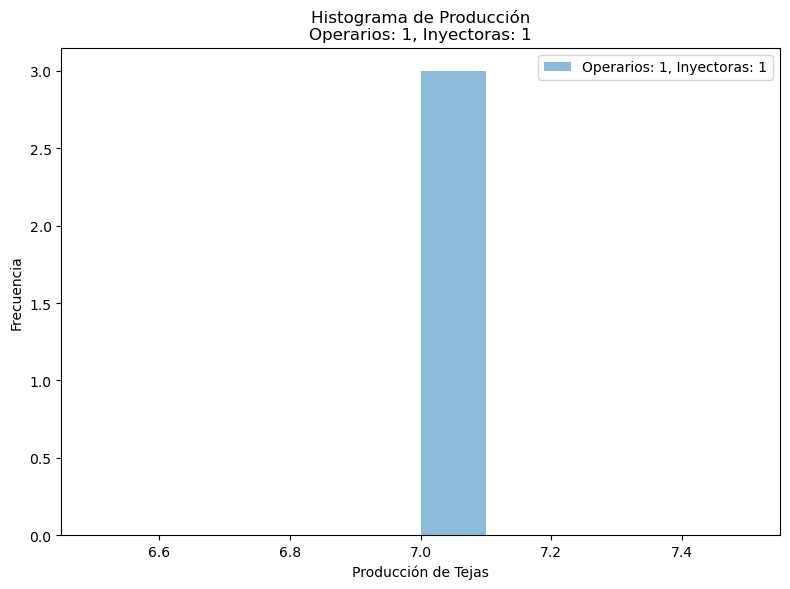

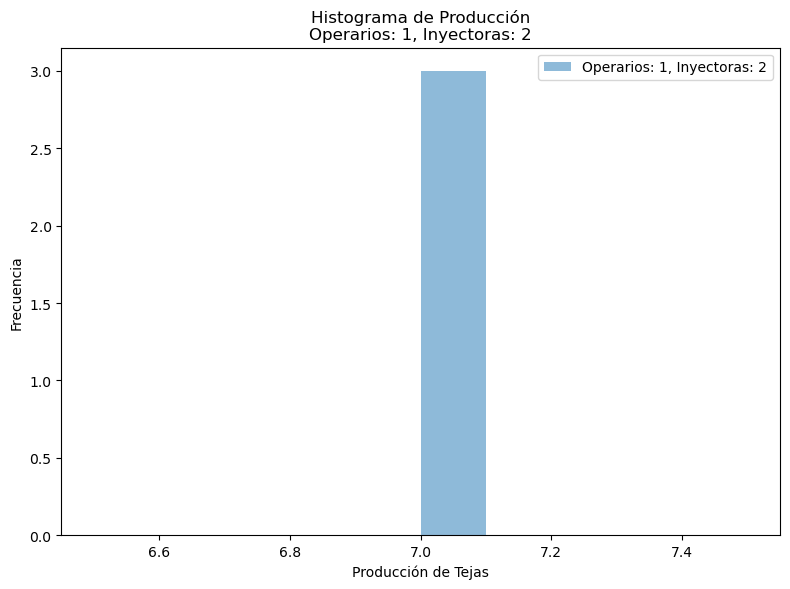

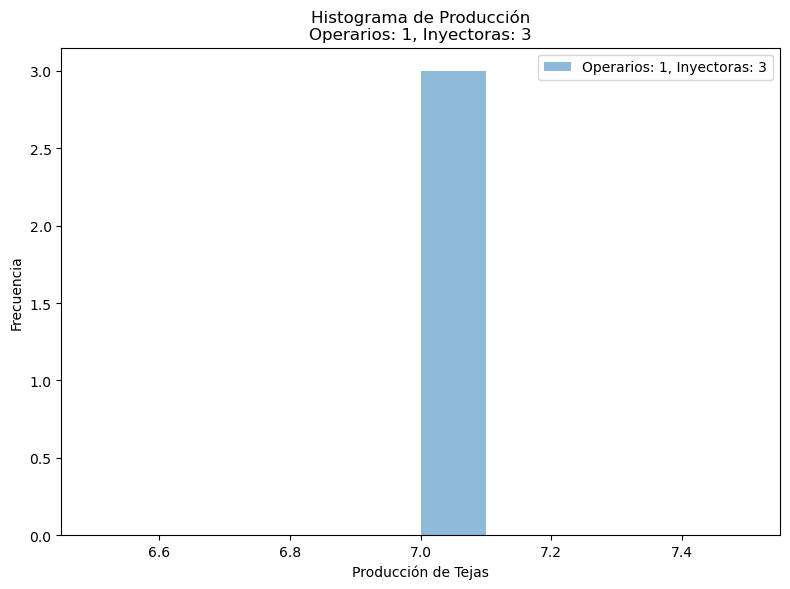

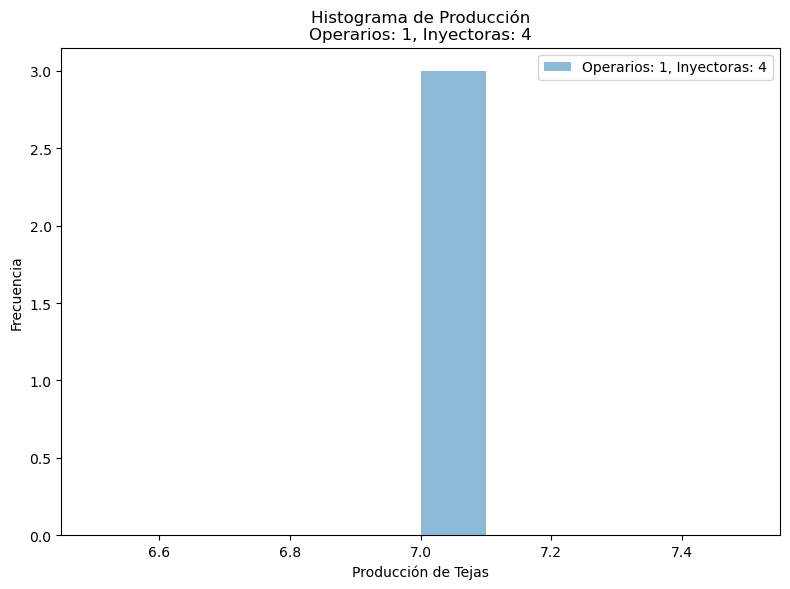

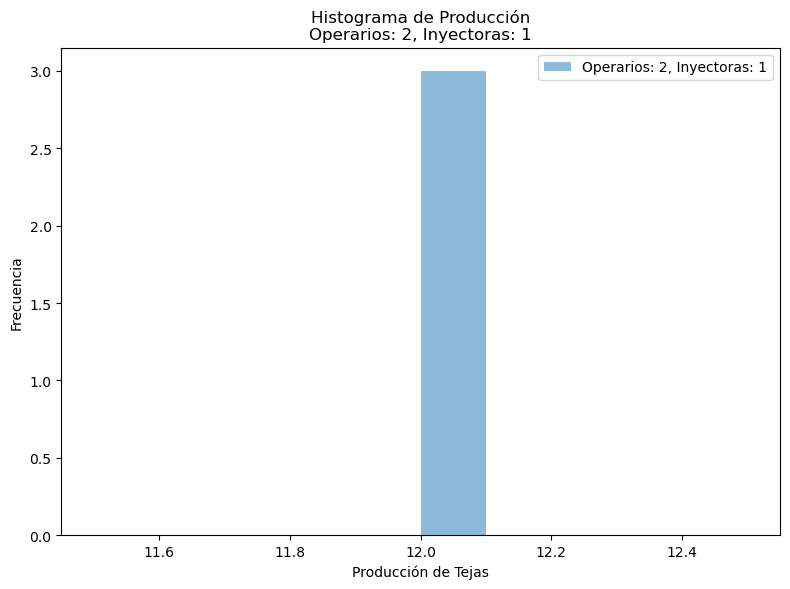

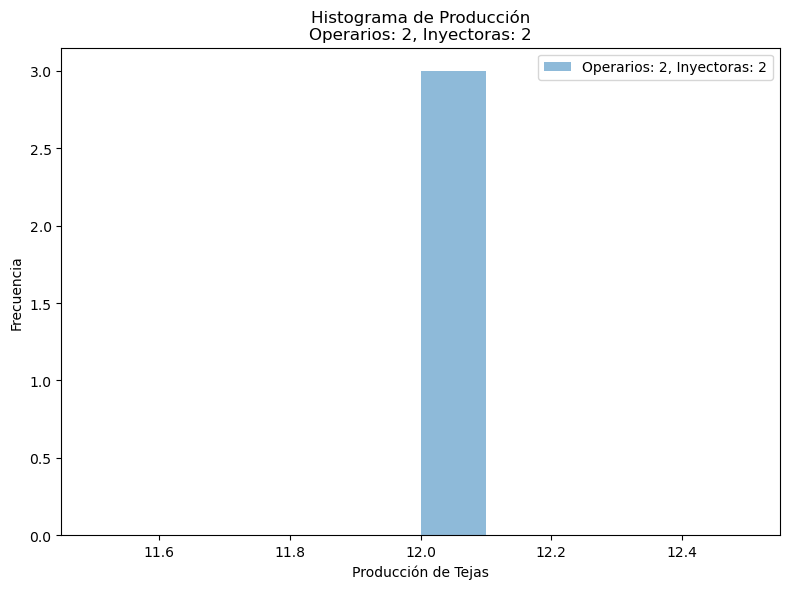

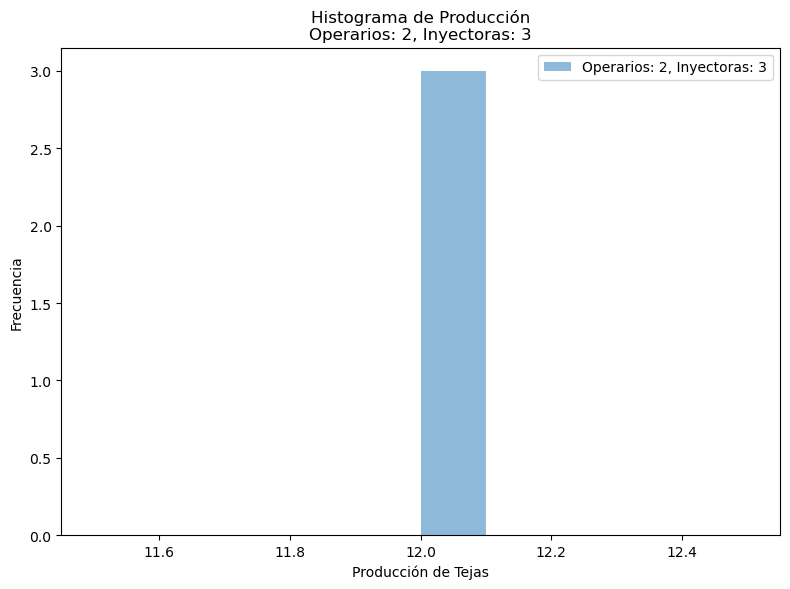

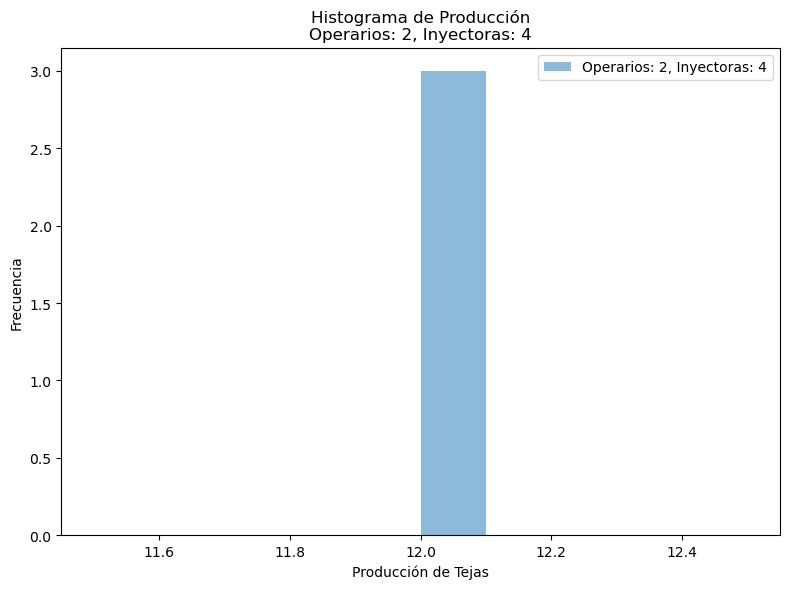

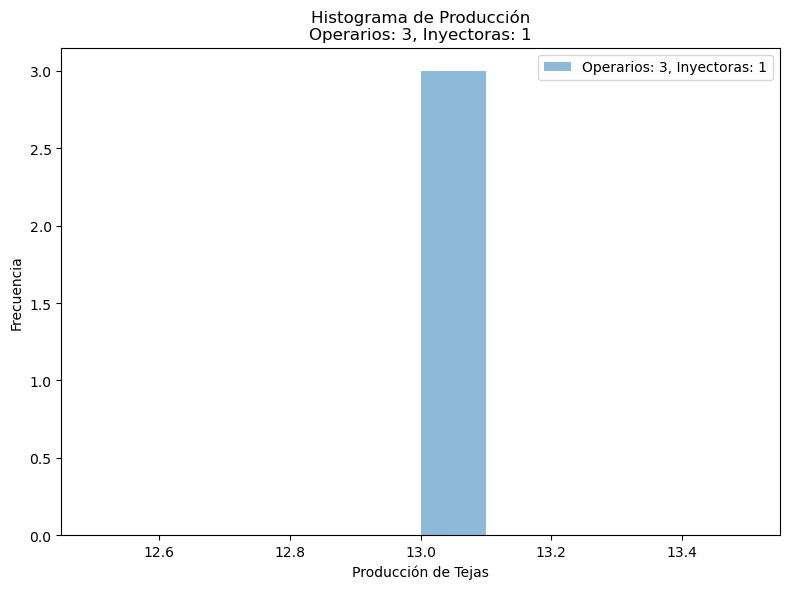

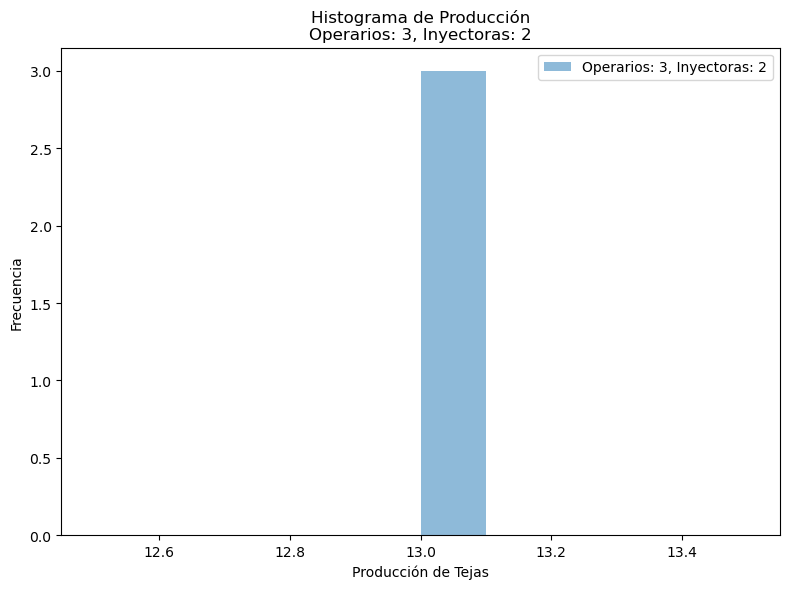

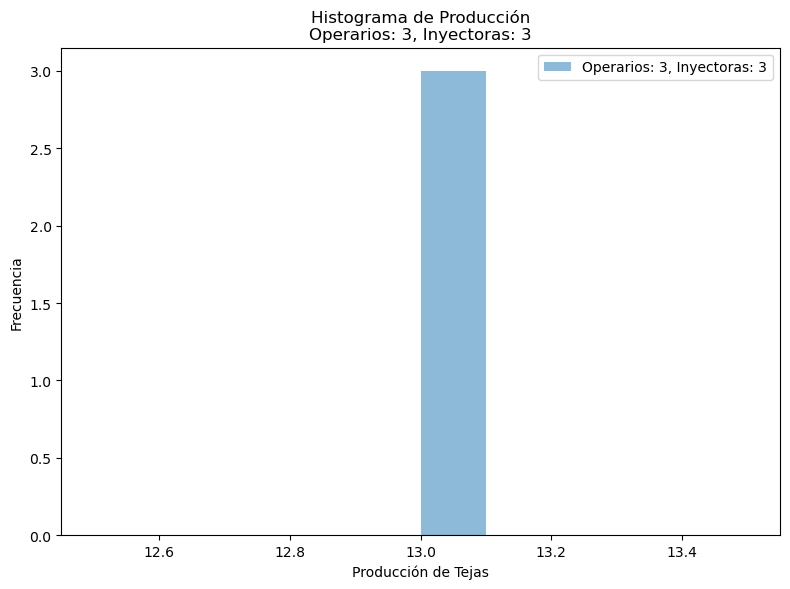

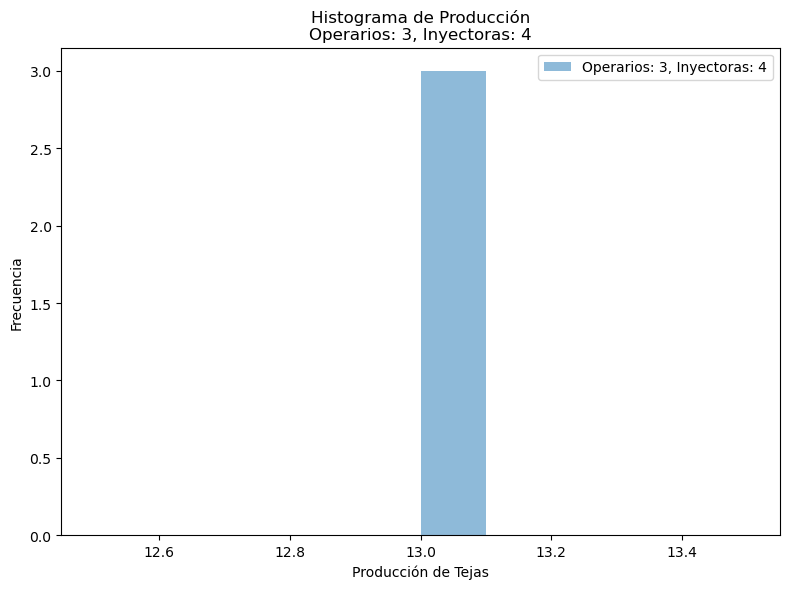

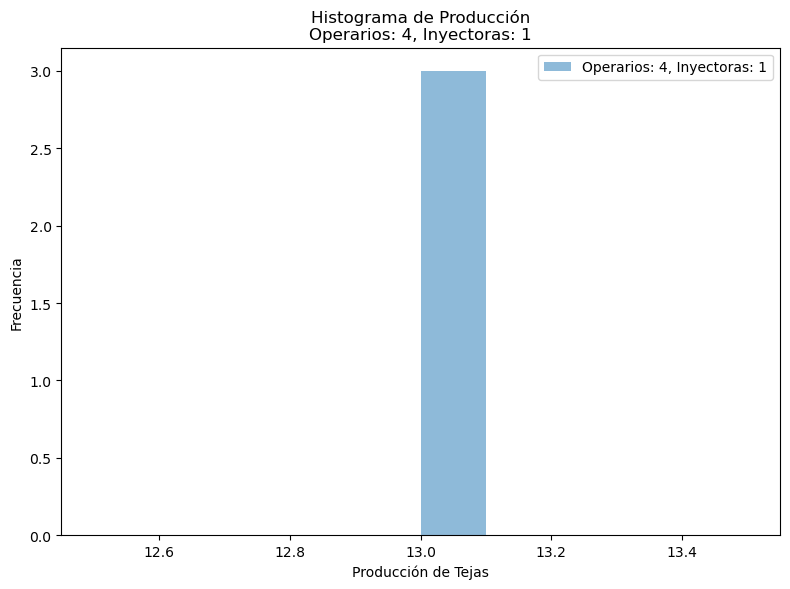

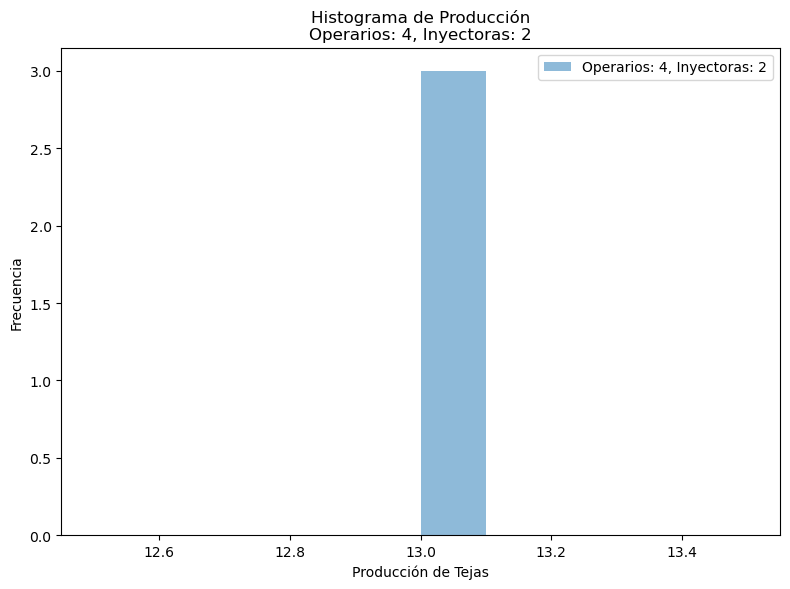

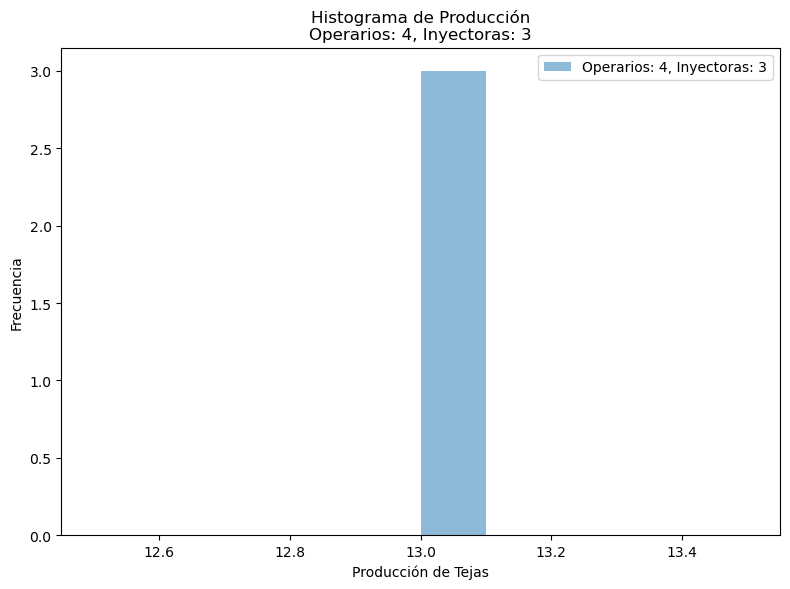

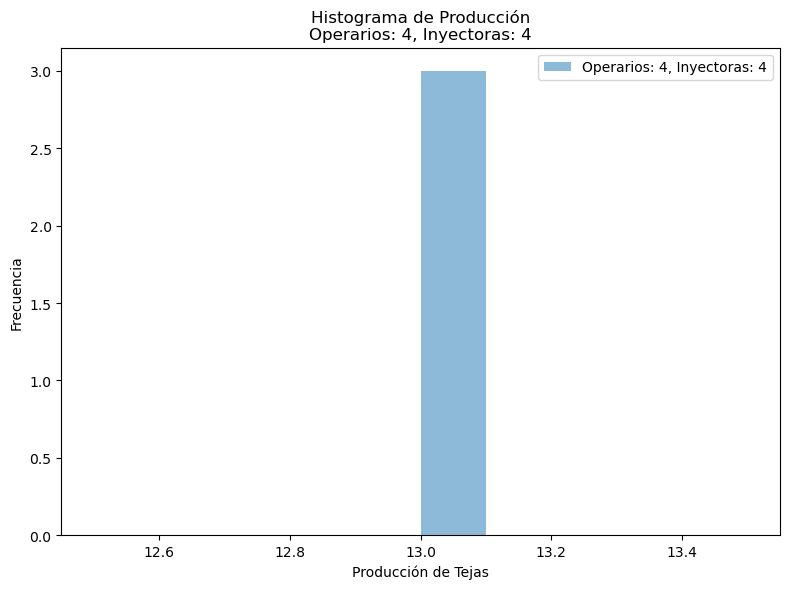

Archivo Excel generado exitosamente en: datos.xlsx
    tiles_production  Tiles_Red  Tiles_Black  Operarios  Inyectoras
0                  7          2            5          1           1
1                  7          2            5          1           1
2                  7          2            5          1           1
3                  7          2            5          1           2
4                  7          2            5          1           2
5                  7          2            5          1           2
6                  7          2            5          1           3
7                  7          2            5          1           3
8                  7          2            5          1           3
9                  7          2            5          1           4
10                 7          2            5          1           4
11                 7          2            5          1           4
12                12          4            8          2          

In [10]:
!pip install salabim --upgrade
import salabim as sim
import pandas as pd
import matplotlib.pyplot as plt

Iter_num = 3
seg_per_day = 28800
Time_MasterbatchxPallet = 1600  # Segundos que tardo en masterbatch para producir un pallet
Pallet_tiles_per_seg = 2000  # Segundos para producir un pallet de tejas

def run_simulation(Operarios, Inyectoras):
    class Counter:
        tiles_production = 0
        Tiles_Red = 0
        Tiles_BlacK = 0

    modelo = sim.Environment(trace=False)
    modelo.number_Pellet = 1203.93

    operator = sim.Resource('Operator', capacity=Operarios)
    masterbatch = sim.Resource('Masterbatch', capacity=Inyectoras)
    injector = sim.Resource('Injector', capacity=1)

    class MasterBatch(sim.Component):
        def process(self):
            if modelo.number_Pellet > 100.32:
                self.request(operator)
                self.request(masterbatch)
                self.hold(sim.Uniform(Time_MasterbatchxPallet, Time_MasterbatchxPallet * 1.1125).sample())
                self.release(masterbatch)
                self.release(operator)
                modelo.number_Pellet -= 100.32  # Decremento en 100.32 KG los pellets

    class Injector(sim.Component):
        def process(self):
            if modelo.number_Pellet > 100.32:
                self.request(operator)
                self.request(injector)
                self.hold(sim.Uniform(Pallet_tiles_per_seg, Pallet_tiles_per_seg * 1.12).sample())
                self.release(operator)
                self.release(injector)
                Counter.tiles_production += 1  # Incremento contador de tejas
                if Counter.Tiles_Red == 0:
                    Counter.Tiles_Red += 1
                elif (Counter.Tiles_Red / (Counter.Tiles_Red + Counter.Tiles_BlacK)) > 0.3:
                    Counter.Tiles_BlacK += 1
                else:
                    Counter.Tiles_Red += 1

    class PalletsGenerator(sim.Component):
        def process(self):
            self.hold(1)
            masterbatch_instance = MasterBatch()
            self.hold(1)
            injector_instance = Injector()

    sim.ComponentGenerator(PalletsGenerator, iat=sim.Exponential(1), force_at=True, number=100)

    modelo.speed(128000*8)
    modelo.run(seg_per_day)

    return Counter.tiles_production, Counter.Tiles_Red, Counter.Tiles_BlacK

results = []
for Operarios in range(1, 5):
    for Inyectoras in range(1, 5):
        for _ in range(Iter_num):
            results.append((*run_simulation(Operarios, Inyectoras), Operarios, Inyectoras))

df = pd.DataFrame(results, columns=['tiles_production', 'Tiles_Red', 'Tiles_Black','Operarios','Inyectoras'])
print(df)

# Agrupar los resultados por combinación de operarios e inyectoras
grouped = df.groupby(['Operarios', 'Inyectoras'])

# Generar histogramas por combinación de operarios e inyectoras
for (operarios, inyectoras), data in grouped:
    plt.figure(figsize=(8, 6))
    plt.hist(data['tiles_production'], bins=10, alpha=0.5, label=f'Operarios: {operarios}, Inyectoras: {inyectoras}')
    plt.xlabel('Producción de Tejas')
    plt.ylabel('Frecuencia')
    plt.title(f'Histograma de Producción\nOperarios: {operarios}, Inyectoras: {inyectoras}')
    plt.legend()
    plt.tight_layout()
    plt.show()

ruta_archivo = 'datos.xlsx'
df.to_excel(ruta_archivo, index=False)

print("Archivo Excel generado exitosamente en:", ruta_archivo)